## Importing

In [23]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error as mse

import os

from time import sleep
from tqdm.auto import tqdm

import dill
import random

import salishsea_tools.viz_tools as sa_vi


## Datasets Preparation

In [24]:
def datasets_preparation ():
    
     ds_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_grid_T.nc')

     ds_bio_name = ('/results2/SalishSea/nowcast-green.202111/' + i + '/SalishSea_1d_'  + '20' + str(i[5:7]) + str(dict_month[i[2:5]])+str(i[0:2]) + '_' + '20' + str(i[5:7]) + str(dict_month[i[2:5]]) + str(i[0:2]) + '_biol_T.nc')
     
     ds = xr.open_dataset (ds_name)
     ds_bio = xr. open_dataset (ds_bio_name)

     date = pd.DatetimeIndex(ds['time_counter'].values)

     temp_i1 = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
          [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     temp_i2 = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
          [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])
     saline_i1 = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
          [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     saline_i2 = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
          [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

     nitr_i1 = (ds_bio.nitrate.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
          [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]
     nitr_i2 = (ds_bio.nitrate.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
          [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])


     diat_i = (ds_bio.diatoms.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
          [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]
     # flag_i = (ds_bio.flagellates.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
     #      [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

     return (date, temp_i1, temp_i2, saline_i1, saline_i2, nitr_i1, nitr_i2, diat_i)


## Regressor

In [25]:
def regressor (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets)

    model = MLPRegressor(hidden_layer_sizes=100, alpha=0.002)
    regr = BaggingRegressor(model, n_estimators=10, n_jobs=2).fit(X_train, y_train)

    outputs_test = regr.predict(X_test)

    m = scatter_plot(y_test, outputs_test, variable_name + ' (Testing dataset)') 
    r = np.round(np.corrcoef(y_test, outputs_test)[0][1],3)
    rms = np.round(mse(y_test, outputs_test),4)
    

    return (r, rms, m, regr)

# Printing

In [26]:
def printing (targets, outputs, m):

    print ('The amount of data points is', outputs.size)
    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(np.corrcoef(targets, outputs)[0][1],3))
    print (' The mean square error is:', np.round(mse(targets,outputs),5))


## Scatter Plot

In [27]:
def scatter_plot(targets, outputs, variable_name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    printing(targets, outputs, m)

    fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

    ax[0].scatter(targets,outputs, alpha = 0.2, s = 10)

    lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()]),]

    # plot fitted y = m*x + b
    ax[0].axline(xy1=(0, b), slope=m, color='r')

    ax[0].set_xlabel('targets')
    ax[0].set_ylabel('outputs')
    ax[0].set_xlim(lims)
    ax[0].set_ylim(lims)
    ax[0].set_aspect('equal')

    ax[0].plot(lims, lims,linestyle = '--',color = 'k')

    h = ax[1].hist2d(targets,outputs, bins=100, cmap='jet', 
        range=[lims,lims], cmin=0.1, norm = 'log')
    
    ax[1].plot(lims, lims,linestyle = '--',color = 'k')

    # plot fitted y = m*x + b
    ax[1].axline(xy1=(0, b), slope=m, color='r')

    ax[1].set_xlabel('targets')
    ax[1].set_ylabel('outputs')
    ax[1].set_aspect('equal')

    fig.colorbar(h[3],ax=ax[1], location='bottom')

    fig.suptitle(str(year) + ', ' + variable_name)

    plt.show()

    return (m)


## Plotting

In [28]:
def plotting(variable,title):
    
    fig, ax = plt.subplots()

    scatter= ax.scatter(dates,variable, marker='.', c=pd.DatetimeIndex(dates).month)

    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])
    fig.suptitle('Daily' + title + ' (15 Feb - 30 Apr)')
    
    fig.show()

## Plotting 2

In [29]:
def plotting2(targets, model, variable, variable_name):

    fig, ax = plt.subplots(2,2, figsize = (10,15))

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    variable.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax =targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    model.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    ((variable-model) / variable * 100).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': variable_name + ' Concentration  [percentage]'})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])


    ax[0,0].title.set_text(variable_name + ' (targets)')
    ax[0,1].title.set_text(variable_name + ' (outputs)')
    ax[1,0].title.set_text('targets - outputs')
    ax[1,1].axis('off')

    fig.suptitle(str(date.date[0]))

    plt.show()
    

## Regressor 2

In [30]:
def regressor2 (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)

    outputs_test = regr.predict(inputs2)
   
    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs_test, deg=1)
    r = np.round(np.corrcoef(targets, outputs_test)[0][1],3)
    rms = np.round(mse(targets, outputs_test),4)

    return (r, rms, m)

## Regressor 3

In [31]:
def regressor3 (inputs, targets, variable_name):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)

    outputs = regr.predict(inputs2)

    # Post processing
    indx2 = np.full((898*398),np.nan)
    indx2[indx[0]] = outputs
    model = np.reshape(indx2,(898,398)) 

    # Preparation of the dataarray 
    model = xr.DataArray(model,
        coords = {'y': diat_i.y, 'x': diat_i.x},
        dims = ['y','x'],
        attrs=dict( long_name = variable_name + " Concentration",
        units="mmol m-2"),)
                        
    plotting2(targets, model, diat_i, variable_name)

## Training of 2011

Gathering days for year 2011


days of 2011:   0%|          | 0/75 [00:00<?, ?it/s]

Done gathering, building the prediction model


The amount of data points is 871482
The slope of the best fitting line is  0.845
The correlation coefficient is: 0.936
 The mean square error is: 0.00302


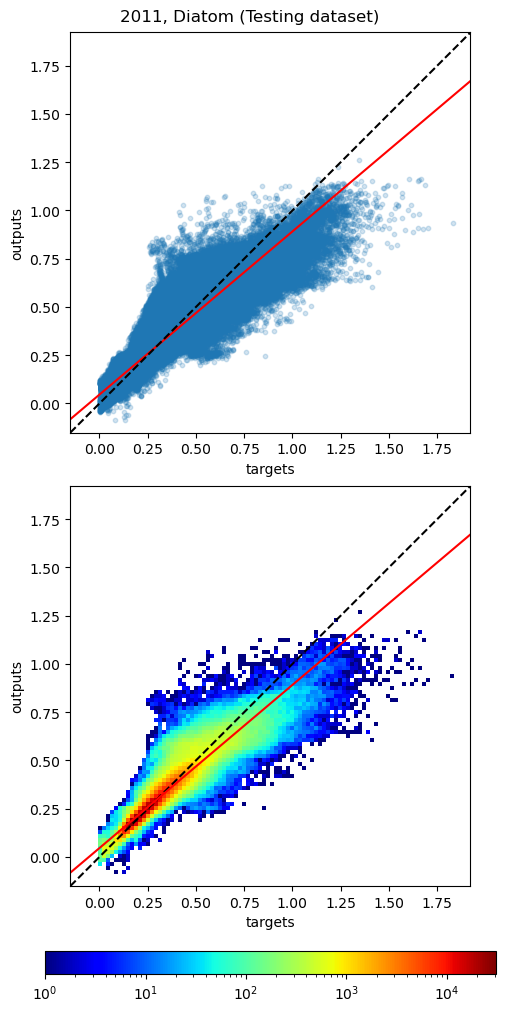

In [32]:
dict_month = {'jan': '01',
         'feb': '02',
         'mar': '03',
         'apr': '04',
         'may': '05',
         'jun': '06',
         'jul': '07',
         'aug': '08',
         'sep': '09',
         'oct': '10',
         'nov': '11',
         'dec': '12'}

path = os.listdir('/results2/SalishSea/nowcast-green.202111/')

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

year = 2011

year_str = str(year)[2:4]

folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '14')) and (x[5:7]==year_str))]
indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
folders = [folders[i] for i in indx_dates]

drivers_all = np.array([[],[],[],[],[],[]])
diat_all = np.array([])

print ('Gathering days for year ' + str(year))

for i in tqdm(folders, desc='days of ' + str(year), colour = 'green'):

    date, temp_i1, temp_i2, saline_i1, saline_i2, nitr_i1, nitr_i2, diat_i = datasets_preparation()

    drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2), np.ravel(nitr_i1), np.ravel(nitr_i2)])
    indx = np.where(~np.isnan(drivers).any(axis=0))
    drivers = drivers[:,indx[0]]
    drivers_all = np.concatenate((drivers_all,drivers),axis=1)

    diat = np.ravel(diat_i)
    diat = diat[indx[0]]
    diat_all = np.concatenate((diat_all,diat))

    sleep(0.1)

print ('Done gathering, building the prediction model')
print ('\n')

r, rms, m, regr = regressor(drivers_all, diat_all, 'Diatom')


## Other Years

  0%|          | 0/1280 [00:00<?, ?it/s]

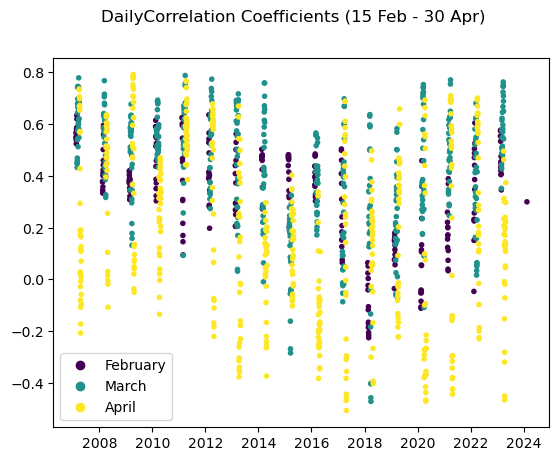

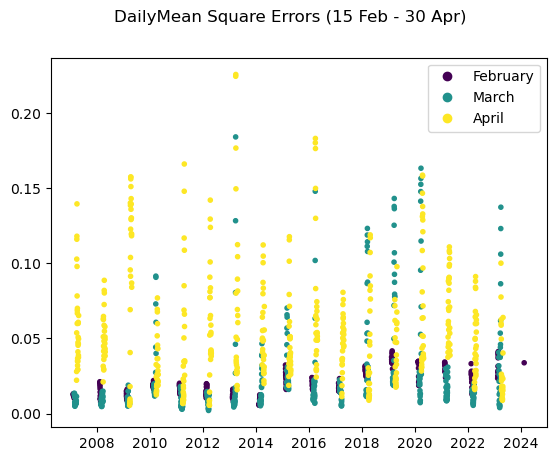

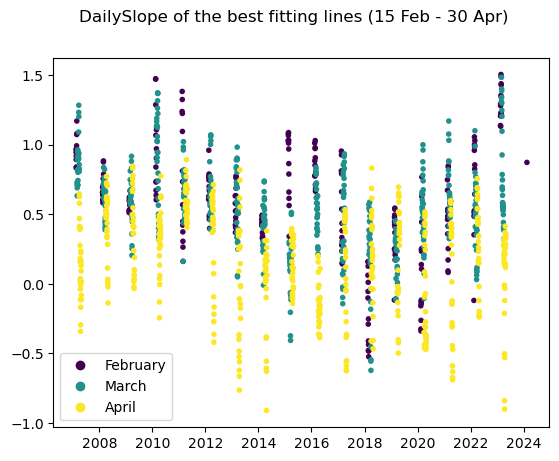

In [33]:
years = range (2007,2024)

dates = np.array([])
r_all = np.array([])
rms_all = np.array([])
slope_all = np.array([])

folders = [x for x in path if ((x[2:5]=='mar' or x[2:5]=='apr' or (x[2:5]=='feb' and x[0:2] > '14')))]
indx_dates=(np.argsort(pd.to_datetime(folders, format="%d%b%y")))
folders = [folders[i] for i in indx_dates]

for i in tqdm(folders, colour = 'green'):
    
    date, temp_i1, temp_i2, saline_i1, saline_i2, nitr_i1, nitr_i2, diat_i = datasets_preparation()

    drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2), np.ravel(nitr_i1), np.ravel(nitr_i2)])
    indx = np.where(~np.isnan(drivers).any(axis=0))
    drivers = drivers[:,indx[0]]

    diat = np.ravel(diat_i)
    diat = diat[indx[0]]

    r, rms, m = regressor2(drivers, diat, 'Diatom')

    dates = np.append(dates,date.date) 
    r_all = np.append(r_all,r)
    rms_all = np.append(rms_all,rms)
    slope_all = np.append(slope_all,m)

plotting(r_all, 'Correlation Coefficients')
plotting(rms_all, 'Mean Square Errors')
plotting (slope_all, 'Slope of the best fitting lines')


# Daily Maps

  0%|          | 0/10 [00:00<?, ?it/s]

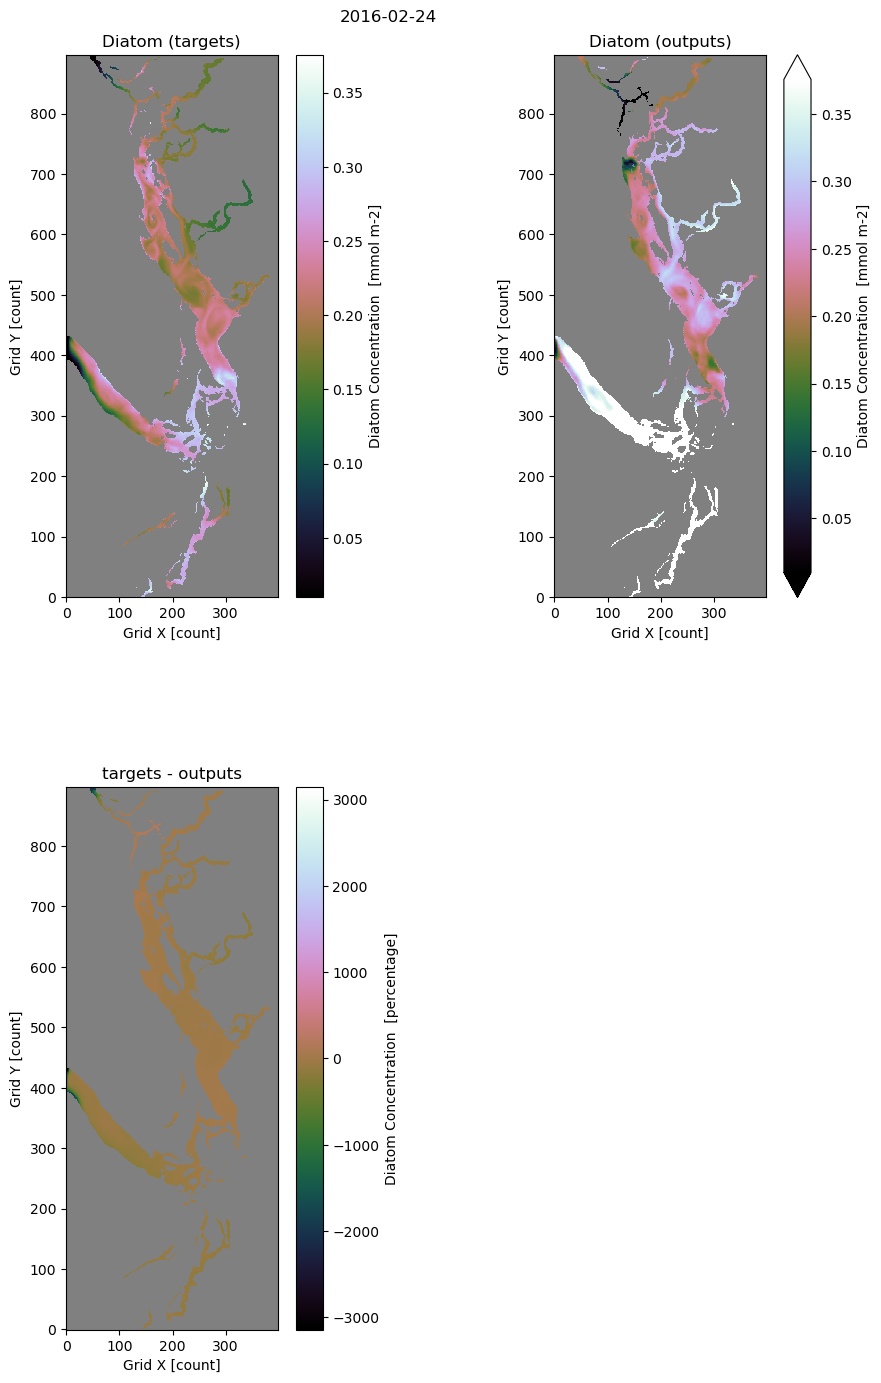

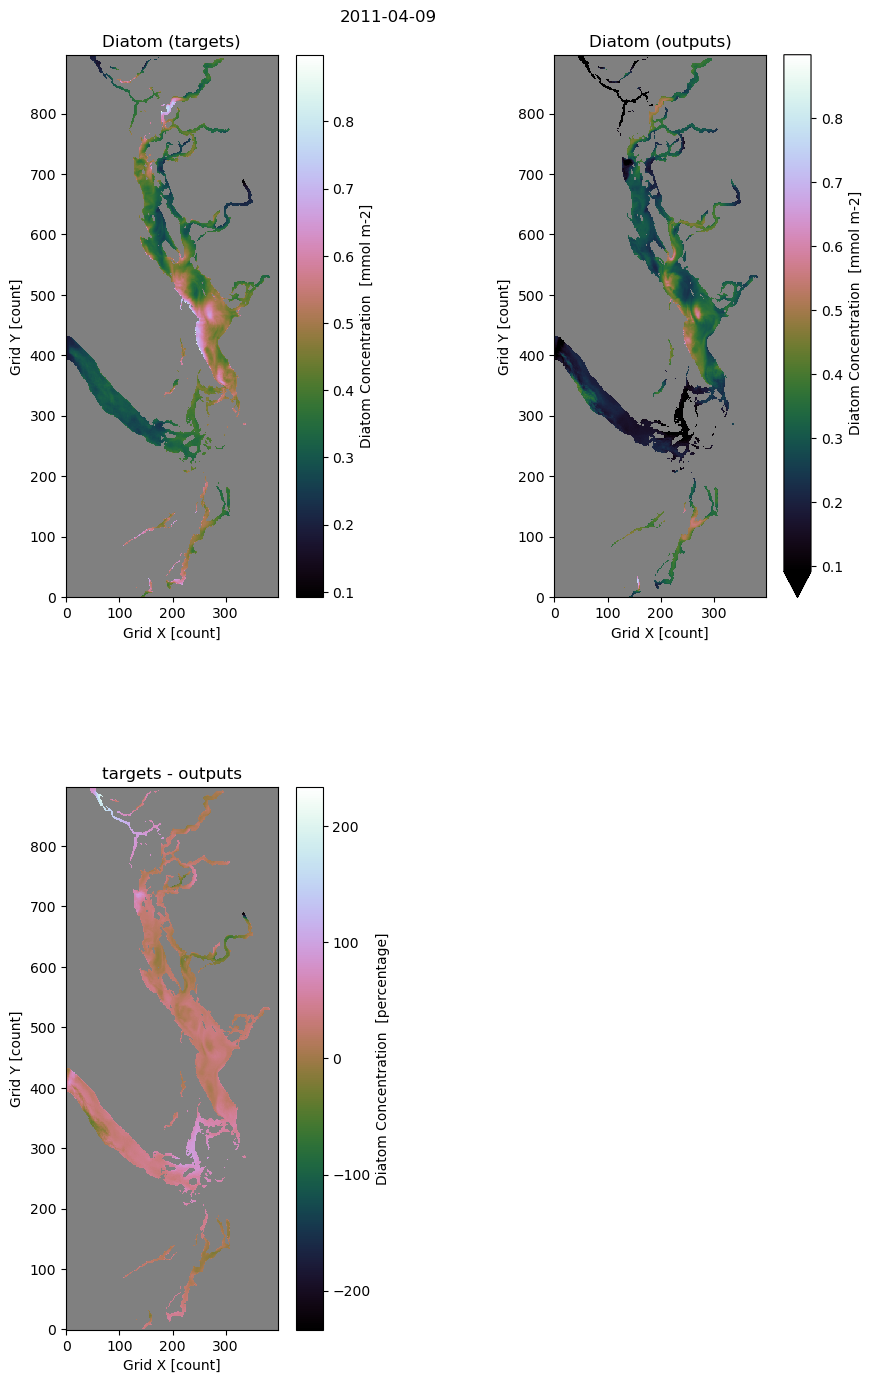

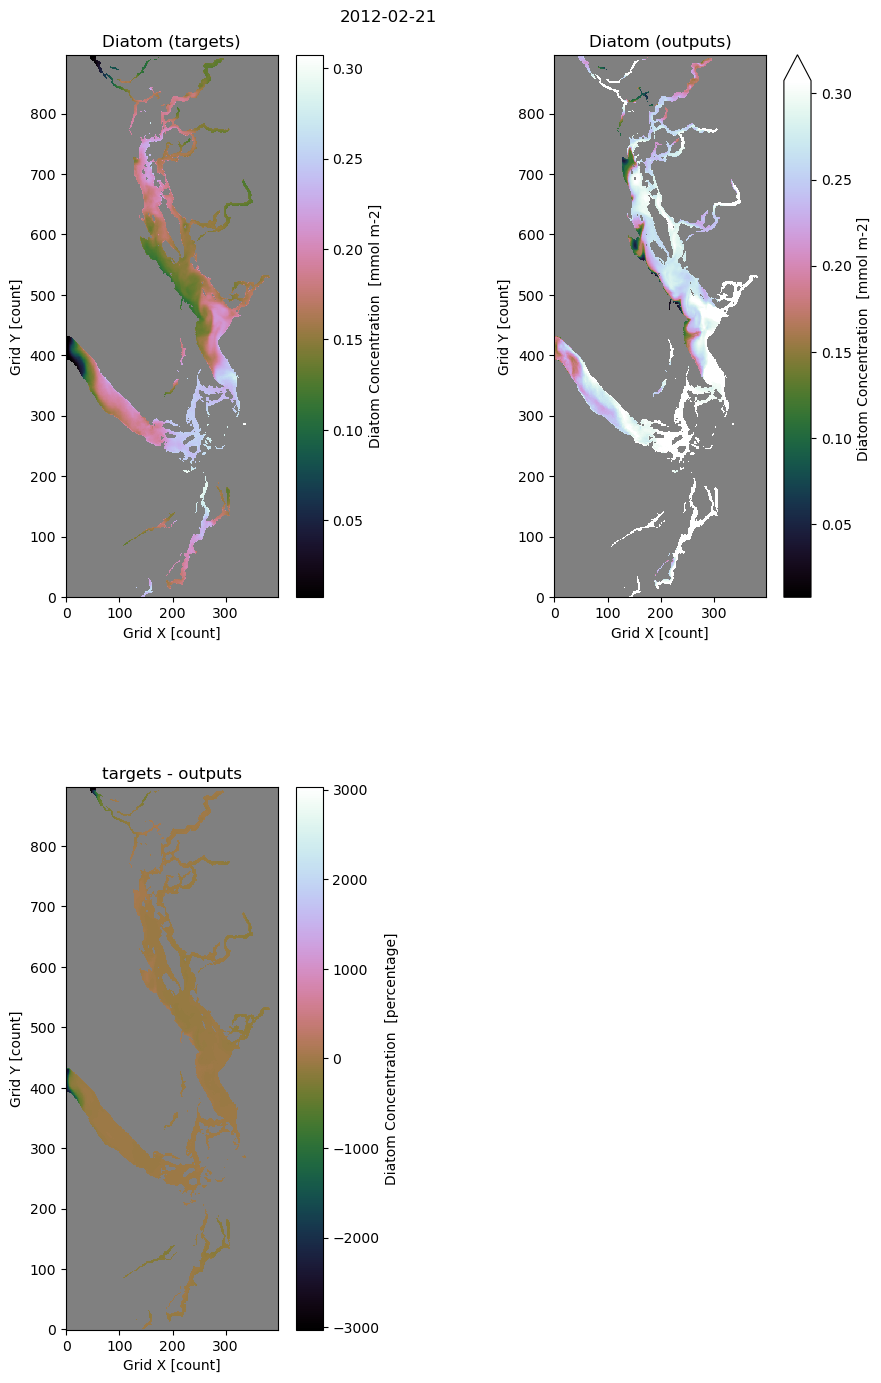

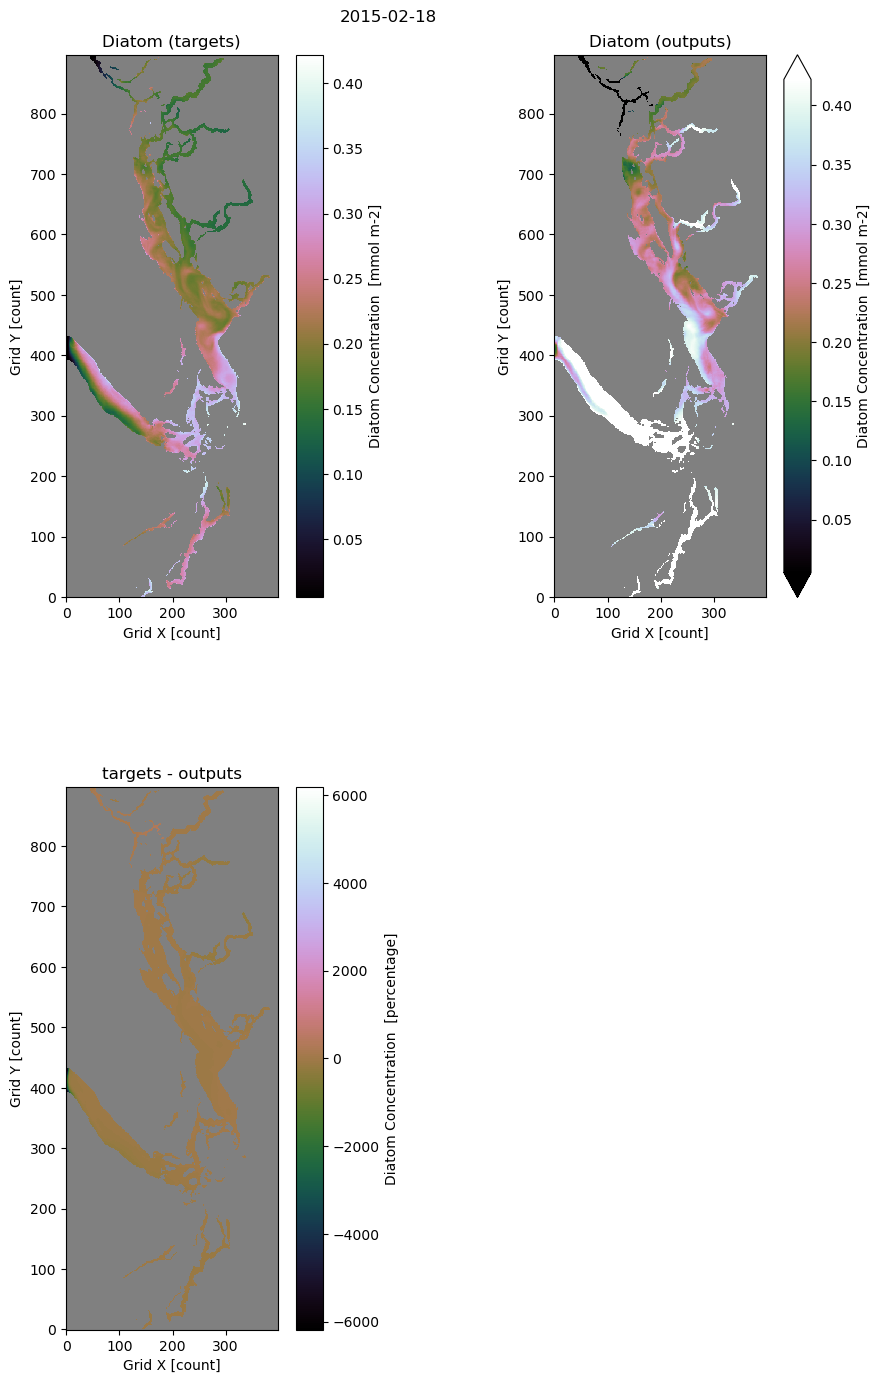

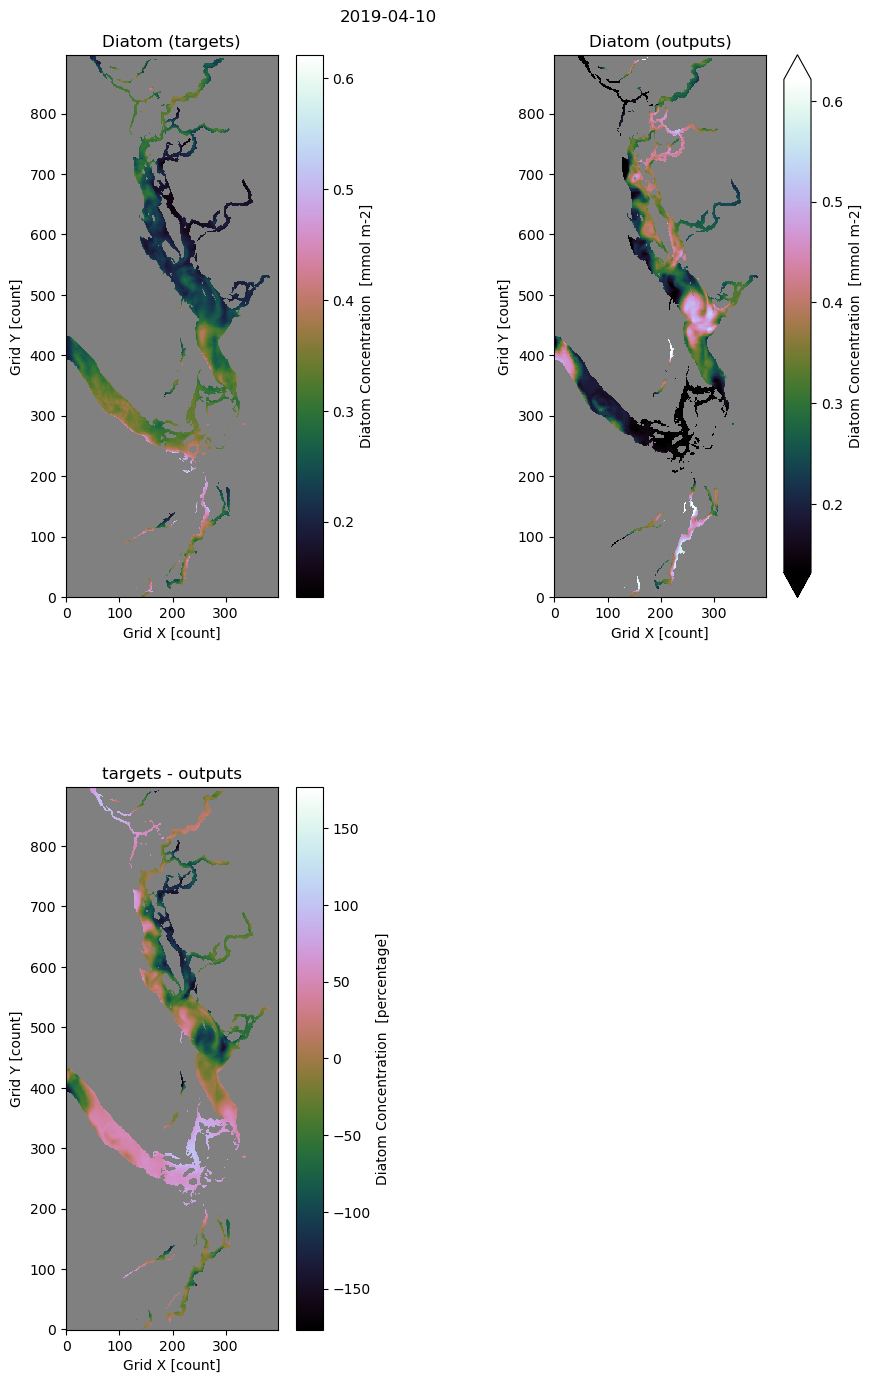

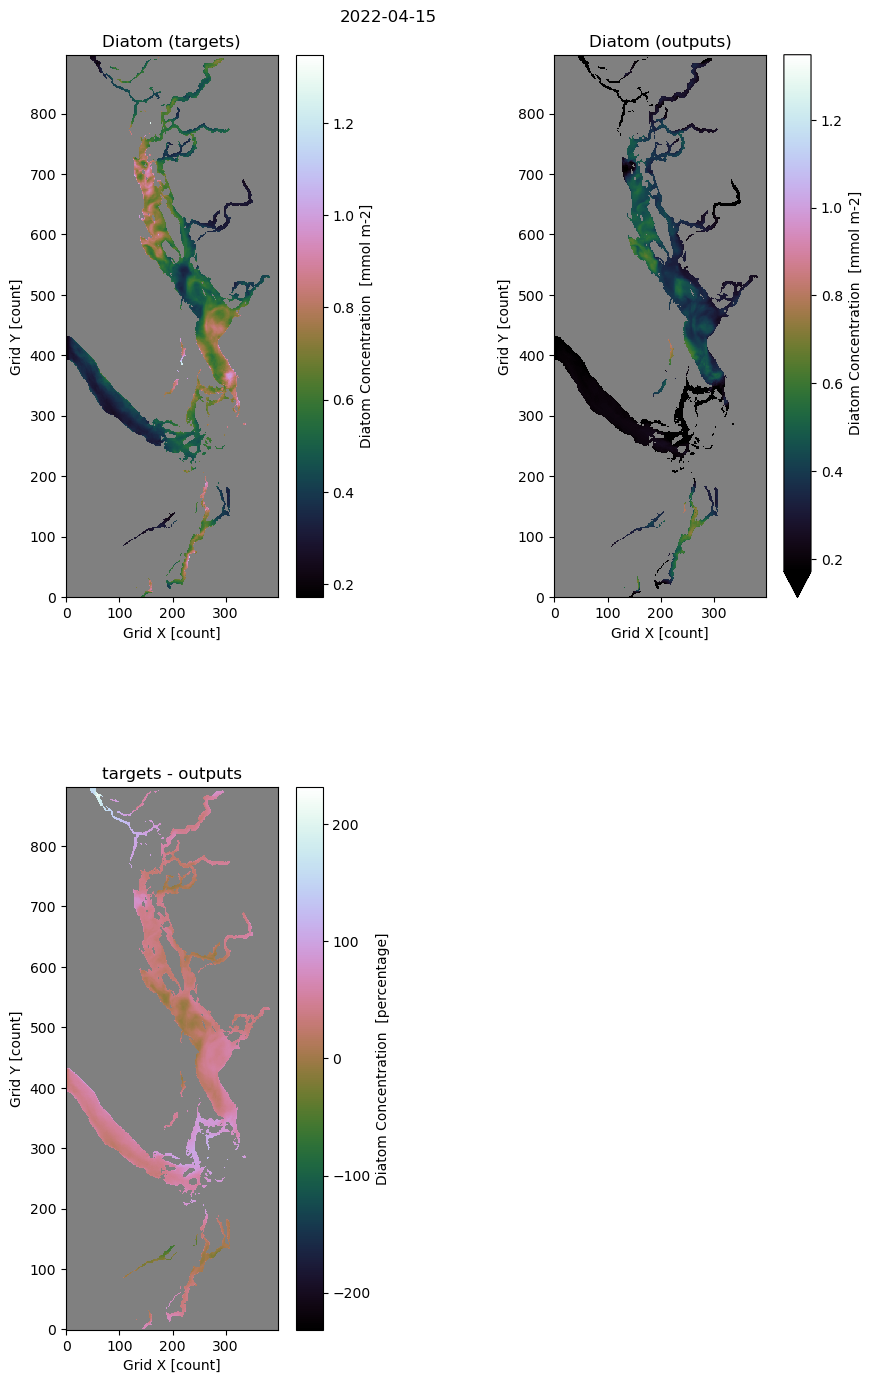

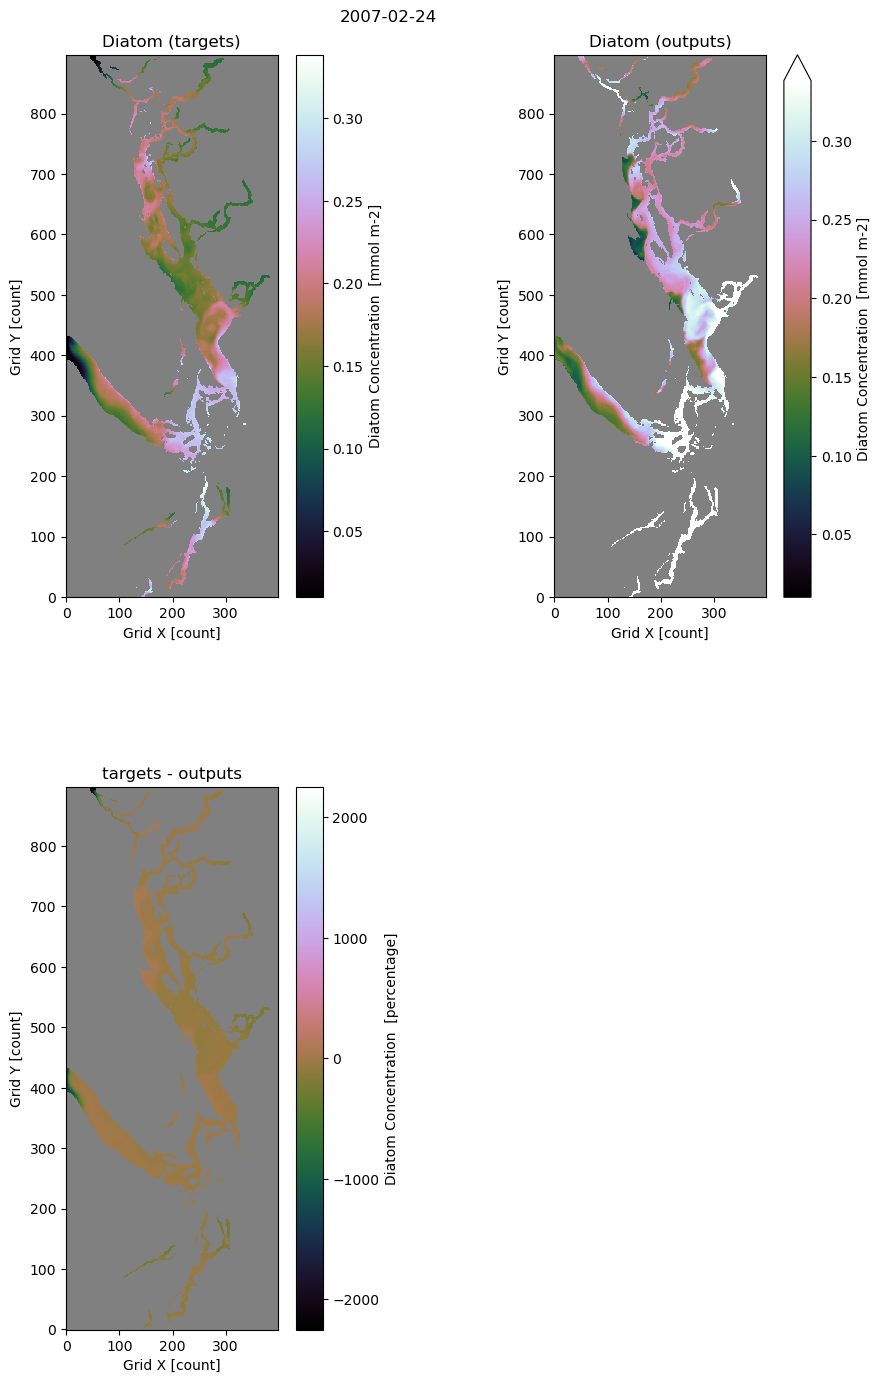

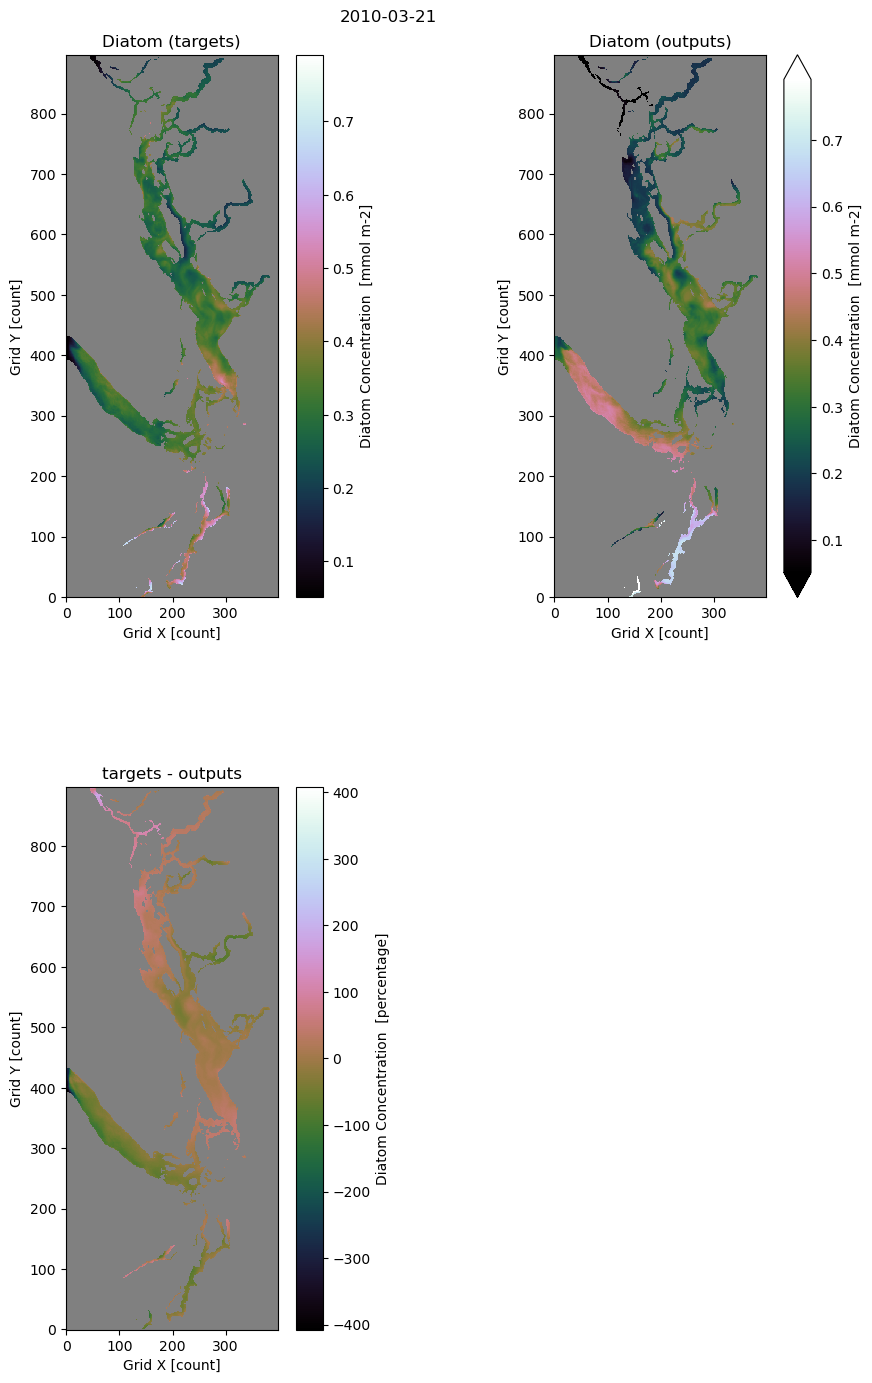

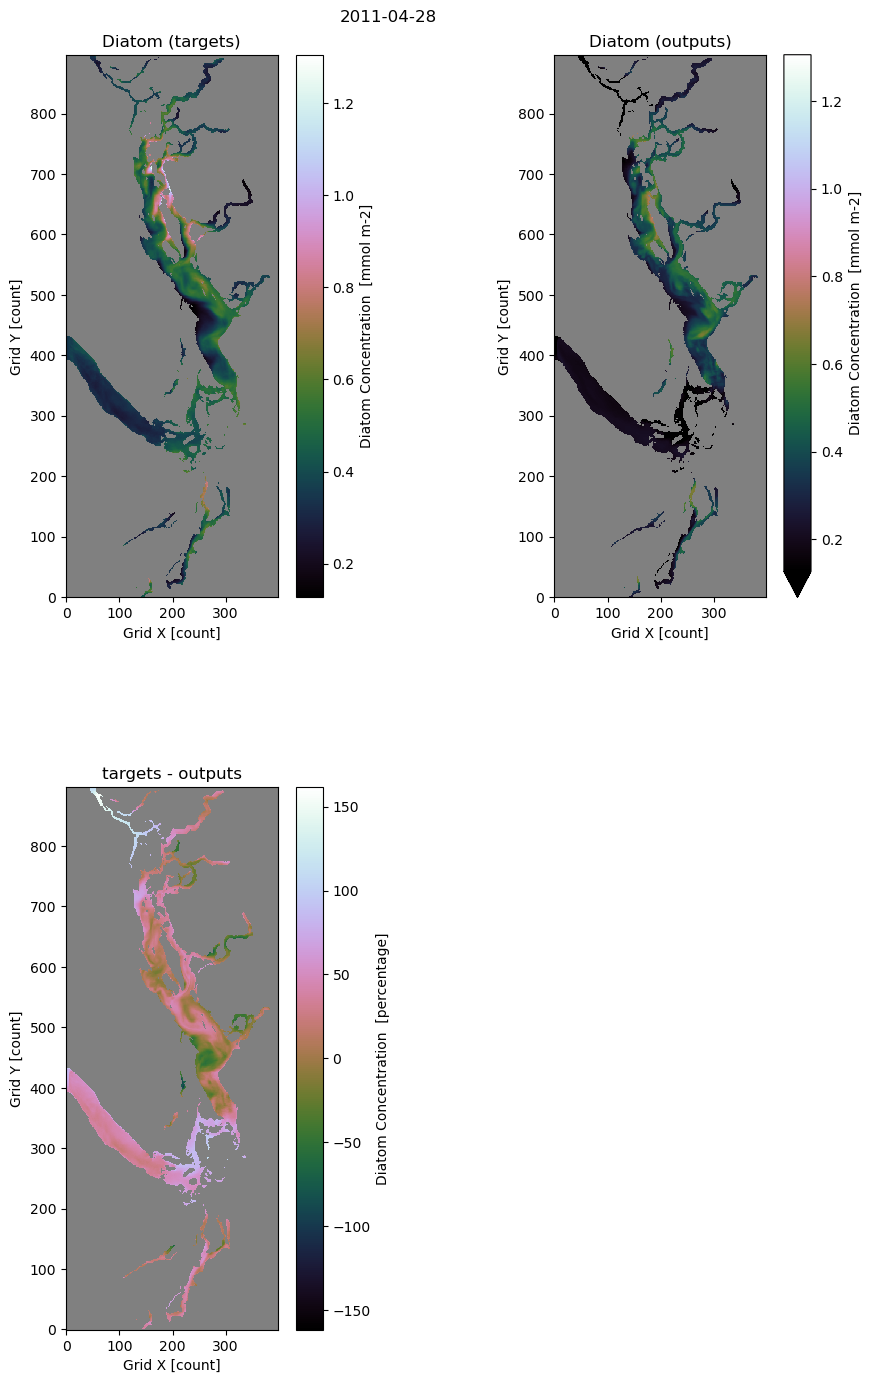

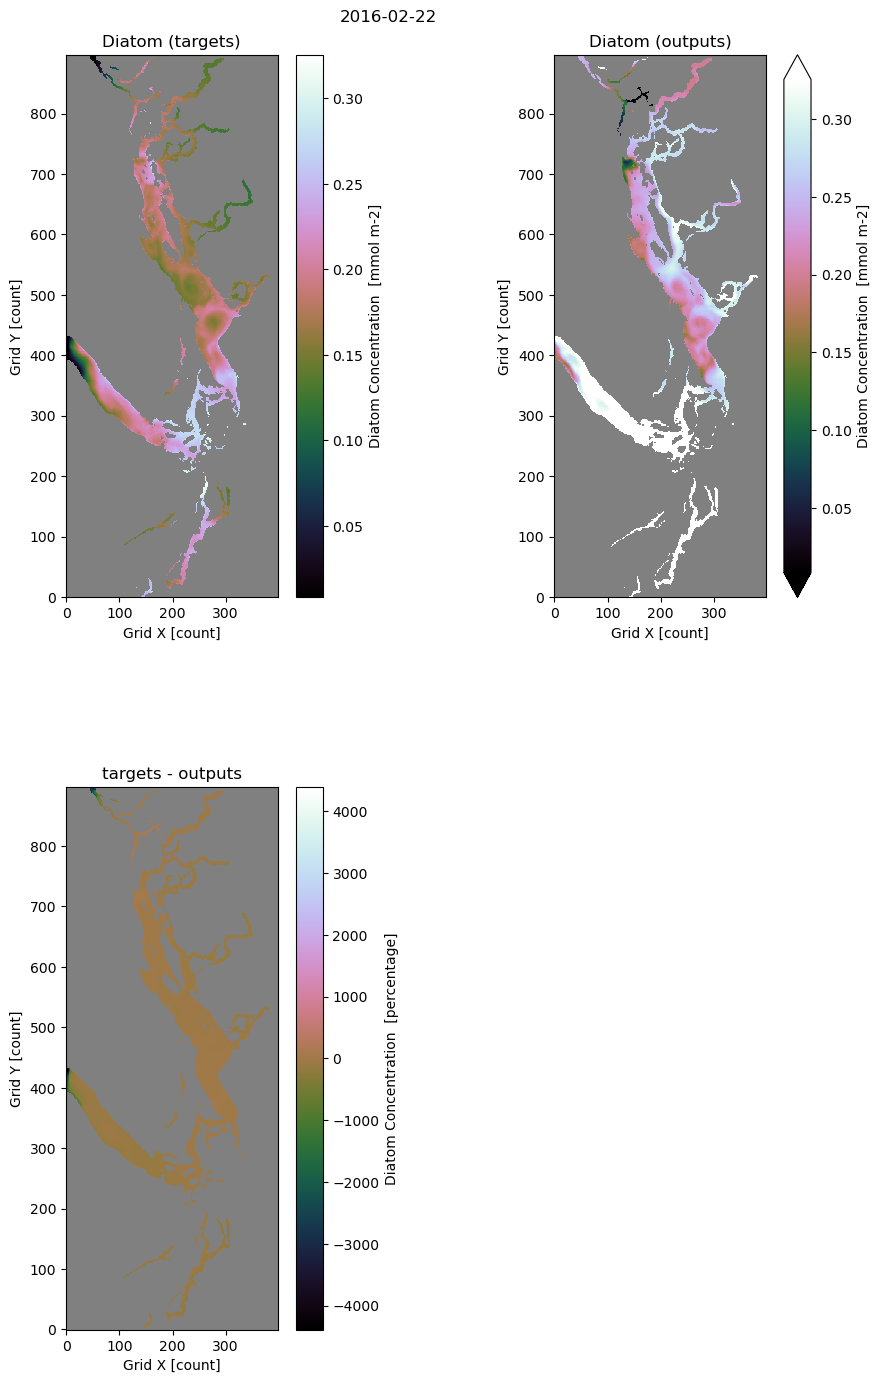

In [34]:
random.shuffle(folders)

for i in tqdm(folders[0:10]):
    
    date, temp_i1, temp_i2, saline_i1, saline_i2, nitr_i1, nitr_i2, diat_i = datasets_preparation()

    drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2), np.ravel(nitr_i1), np.ravel(nitr_i2)])
    indx = np.where(~np.isnan(drivers).any(axis=0))
    drivers = drivers[:,indx[0]]

    diat = np.ravel(diat_i)
    diat = diat[indx[0]]

    regressor3(drivers, diat, 'Diatom')
